https://www.youtube.com/watch?v=UuteCccDXCE&list=PLQVvvaa0QuDdeMyHEYc0gxFpYwHY2Qfdh&index=8

In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


#in your pre-processing dataset you dont want to build data everytime you run your code
REBUILD_DATA = False

class DogsVSCats():
    IMG_SIZE = 50
    CATS = "kagglecatsanddogs_3367a/PetImages/Cat"
    DOGS = "kagglecatsanddogs_3367a/PetImages/Dog"
    #Pre-labelled data
    LABELS ={CATS: 0, DOGS: 1}
    # massive list of images with their label
    training_data = []
    cat_count = 0
    dog_count = 0
        
    def make_training_data(self):
        for label in self.LABELS:
            print("directory: ",label)
            #looping all the images in the directory
            for f in tqdm(os.listdir(label)):
                try:
                    path = os.path.join(label,f)
                    img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                    self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])
                    if label == self.CATS:
                        self.cat_count += 1
                    elif label == self.DOGS:
                        self.dog_count += 1
                except Exception as e:
                    pass                   
        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print("Cats:", self.cat_count)
        print("Dogs:", self.dog_count)
            
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,32,5)
        self.conv2 = nn.Conv2d(32,64,5)
        self.conv3 = nn.Conv2d(64,128,5)
        x = torch.randn(50,50).view(-1,1,50,50)
        self._to_linear = None
        self.convs(x)
        
        # self.fc1 = nn.Linear ( ??? , 512)
        self.fc1 = nn.Linear(self._to_linear,512)
        self.fc2 = nn.Linear(512,2)
    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))
        
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x
    def forward (self,x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim = 1)

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("running on the GPU")
else:
    device = torch.device("cpu")
    print("running on the CPU")

    
# Initialize model    
net = Net().to(device)


if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()
    
training_data = np.load("training_data.npy", allow_pickle=True)
print("Train data length :",len(training_data))

optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

X = torch.Tensor([i[0] for i in training_data]).view(-1,50,50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)
print("Test data length :",val_size)

train_X = X[: -val_size]
train_y = y[: -val_size]
test_X = X[-val_size:]
test_y = y[-val_size:]

print("train_X is : ",len(train_X), "with train_y : ", len(train_y))
print("test_X is : ",len(test_X), "with test_y : ", len(test_y))

running on the GPU
Train data length : 24946
Test data length : 2494
train_X is :  22452 with train_y :  22452
test_X is :  2494 with test_y :  2494


In [2]:
# create function that accepts data that we pass and returns outputs
# calculates graident and loss

# create forward pass function
#checking for both in sample and out of sample test
def fwd_pass(X, y, train=False):
    if train:
        net.zero_grad()
    outputs = net(X)
    matches = [torch.argmax(i) == torch.argmax(j) for i,j in zip(outputs,y)]
    acc = matches.count(True)/len(matches)
    loss = loss_function(outputs, y)
    
    if train:
        loss.backward()
        optimizer.step()
    return acc, loss

In [52]:
def test(size=32):
    random_start = np.random.randint(len(test_X) - size)
    # print(random_start)
    X, y = test_X[random_start:size+random_start], test_y[random_start:random_start + size]
    with torch.no_grad():
        print(X.shape)
        val_acc, val_loss = fwd_pass(X.view(-1,1,50,50).to(device),y.to(device))
    return val_acc, val_loss

val_acc, val_loss = test(size = 1)
print(val_acc, val_loss)

#tensor board - visualization module in tensor flow

torch.Size([1, 50, 50])
1.0 tensor(0.1295, device='cuda:0')


In [4]:
import time

MODEL_NAME = f"model-{int(time.time())}"
net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

print(MODEL_NAME)

def train():
    BATCH_SIZE = 100
    EPOCHS = 8
    with open("model.log", "a") as f:
        for epoch in range(EPOCHS):
            for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
                batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,50,50).to(device)
                batch_y = train_y[i:i+BATCH_SIZE].to(device)
                
                acc, loss = fwd_pass(batch_X, batch_y, train=True)
                # start logging data
                # problem: every step you take -> double training time
                # do it at larger size but not at every step
                if i % 50 == 0:
                    #validation accuracy and loss
                    val_acc, val_loss = test(size=100)
                    f.write(f"{MODEL_NAME},{round(time.time(),3)}, {round(float(acc),2)},{round(float(loss),4)}, {round(float(val_acc),2)},{round(float(val_loss),4)}\n")
        
train()
    

  1%|          | 2/225 [00:00<00:17, 12.89it/s]

model-1590211477


100%|██████████| 225/225 [00:14<00:00, 15.08it/s]


24946


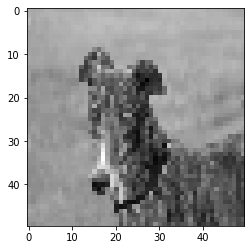

(50, 50)


In [76]:
#original input data
import matplotlib.pyplot as plt
print(len(training_data))
index = 26
plt.imshow(training_data[index][0], cmap= "gray")
plt.show()
print(training_data[index][0].shape)

In [101]:
#mocking data coming into the system
#input data is in np array 
input_X, labelled_y = training_data[index] 
# convert numpy to tensor - note single tensor should have the dimention [1,50,50]
# Note: input_X, labeled_y = test_X[index:index+1],test_y[index:index+1]
input_X = torch.Tensor([input_X]).view(-1,50,50)
labelled_y = torch.Tensor([labelled_y])
# Normalisation value from 0 - 1
input_X = input_X / 255.0
with torch.no_grad():
    outputs = net(input_X.view(-1,1,50,50).to(device))

match = [torch.argmax(i) == torch.argmax(j) for i,j in zip(outputs,labelled_y)]
print(match)
print("input X in tensor value ", input_X)
print("labelled y in tensor ", labelled_y)
print("output from the model ", outputs)



[tensor(True, device='cuda:0')]
input X in tensor value  tensor([[[0.6784, 0.6588, 0.6667,  ..., 0.6549, 0.6510, 0.6549],
         [0.6902, 0.6706, 0.6824,  ..., 0.6706, 0.6588, 0.6588],
         [0.7294, 0.6627, 0.6902,  ..., 0.6941, 0.6941, 0.6863],
         ...,
         [0.6353, 0.6157, 0.5961,  ..., 0.3412, 0.2980, 0.2863],
         [0.6078, 0.6118, 0.6157,  ..., 0.3804, 0.3294, 0.3961],
         [0.5961, 0.5647, 0.6039,  ..., 0.4275, 0.3216, 0.3529]]])
labelled y in tensor  tensor([[0., 1.]])
output from the model  tensor([[0.1827, 0.8173]], device='cuda:0')


In [104]:
# Saving and loading the model https://pytorch.org/tutorials/beginner/saving_loading_models.html

# Print model's state_dict
print("Model's state_dict:")
for param_tensor in net.state_dict():
    print(param_tensor, "\t", net.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])    

Model's state_dict:
conv1.weight 	 torch.Size([32, 1, 5, 5])
conv1.bias 	 torch.Size([32])
conv2.weight 	 torch.Size([64, 32, 5, 5])
conv2.bias 	 torch.Size([64])
conv3.weight 	 torch.Size([128, 64, 5, 5])
conv3.bias 	 torch.Size([128])
fc1.weight 	 torch.Size([512, 512])
fc1.bias 	 torch.Size([512])
fc2.weight 	 torch.Size([2, 512])
fc2.bias 	 torch.Size([2])
Optimizer's state_dict:
state 	 {2160401752776: {'step': 1800, 'exp_avg': tensor([[[[-2.8220e-05,  2.2973e-04,  2.6306e-05,  1.0007e-03,  5.5387e-04],
          [ 2.7882e-05, -2.7320e-05, -5.6632e-04,  1.5736e-04,  3.7161e-06],
          [ 7.3465e-04,  2.2128e-04, -1.7697e-04,  1.9789e-05,  4.8186e-05],
          [-1.7597e-04, -1.3628e-04, -4.8166e-04, -1.7682e-04,  1.8245e-05],
          [ 2.9714e-04, -1.2932e-04, -1.8131e-04,  1.0110e-04, -1.4101e-05]]],


        [[[ 9.9772e-05,  1.0215e-03,  3.3338e-03,  5.5719e-03,  5.7391e-03],
          [-2.1295e-03, -1.2488e-03, -1.8238e-05,  2.6830e-03,  5.5253e-03],
          [-2.9025e-

In [112]:
#Saving the pytorch model
import os
PATH = os.path.join(os.getcwd(), MODEL_NAME)
print(PATH)
torch.save(net.state_dict(), PATH)

C:\Users\josep\Code\pyTorch Tutorial\model-1590211477


In [115]:
#loading the pytorch model
model = Net()
model.load_state_dict(torch.load(PATH))
model.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

In [118]:
outputs = model(input_X.view(-1,1,50,50))
print(outputs)

tensor([[0.1827, 0.8173]], grad_fn=<SoftmaxBackward>)
